# Set up and import dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import random

# Set path to local data directory
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Display dataset dimensions and column names
print("Feature DF:", feature_df.shape)
print("Target DF:", target_df.shape)
print("\nFeature columns:", feature_df.columns.tolist())
print("\nTarget columns:", target_df.columns.tolist())

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Preview top and bottom of the stacked DataFrame
print("\nConcat DF (head):")
display(combined_df.head())

print("\nConcat DF (tail):")
display(combined_df.tail())

# Set seed for reproducibility
np.random.seed(3888)
random.seed(3888)

Feature DF: (17646119, 11)
Target DF: (17911332, 11)

Feature columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Target columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']


# Feature Engineering

In [ ]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033


In [ ]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()


,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


# Combine date and time into a full datetime column


In [ ]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()

,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


# Time ID to Real Time Mapping
NaT (Not a Time) means the merge didn’t find a matching time_id in time_ref_df
For example, time_id 6

In [ ]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()

feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
4166343,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,2021-10-07 16:00:00
4166344,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,2021-10-07 16:00:00
4166345,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,2021-10-07 16:00:00
4166346,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00
4166347,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00


# Train/Test Split 
## Chronological time_id-based split (80/20)

In [ ]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)


TimeID Split:
Train shape: (3332063, 9)
Test shape: (834285, 9)


# Modeling with one stock 
Each stock has its own dynamics, so we usually train per stock

Each stock might behave diffrently to diffrent models and will required diffrent tuning 

In [ ]:
# Example with SPY XNAS
spy_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
print(spy_df.tail())

# Check the datetime available
spy_df["date_only"] = spy_df["datetime"].dt.date




         stock_id  time_id  seconds_in_bucket         wap  spread_pct  \
4163951    104919     1199             1203.0  364.321250    0.000027   
4163952    104919     1199             1204.0  364.319165    0.000027   
4163953    104919     1199             1205.0  364.309375    0.000027   
4163983    104919     1199             1235.0  364.313529    0.000027   
4166347    104919     1199             3599.0  362.804000    0.000028   

         imbalance  depth_ratio  spread_variation            datetime  
4163951  -0.750000     0.142857      5.942506e-10 2021-10-07 16:00:00  
4163952   0.832994    10.975610      7.491700e-10 2021-10-07 16:00:00  
4163953   0.875000    15.000000      9.562752e-10 2021-10-07 16:00:00  
4163983  -0.294118     0.545455      1.157306e-05 2021-10-07 16:00:00  
4166347  -0.200000     0.666667      1.162395e-05 2021-10-07 16:00:00  


<Axes: title={'center': 'SPY: Spread % Over Time'}, xlabel='datetime'>

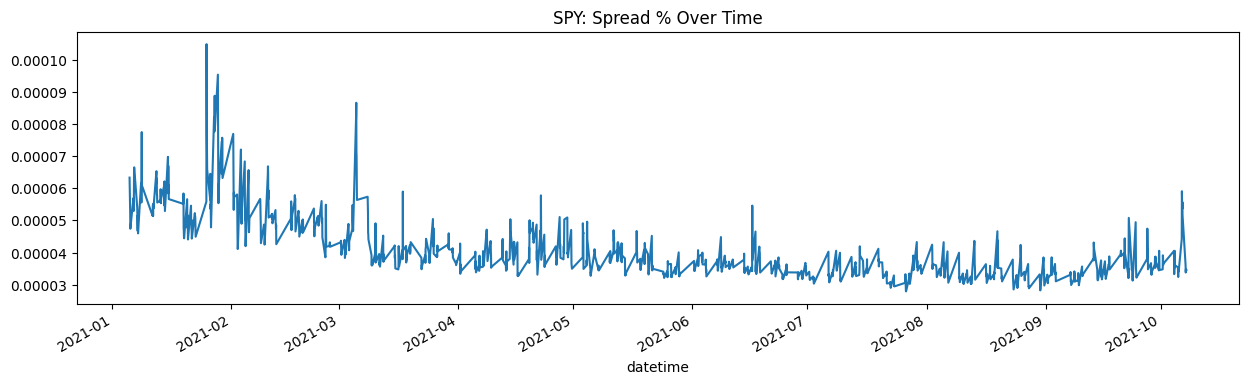

In [ ]:
spy_df.groupby("datetime")["spread_pct"].mean().plot(
    figsize=(15,4), title="SPY: Spread % Over Time"
)

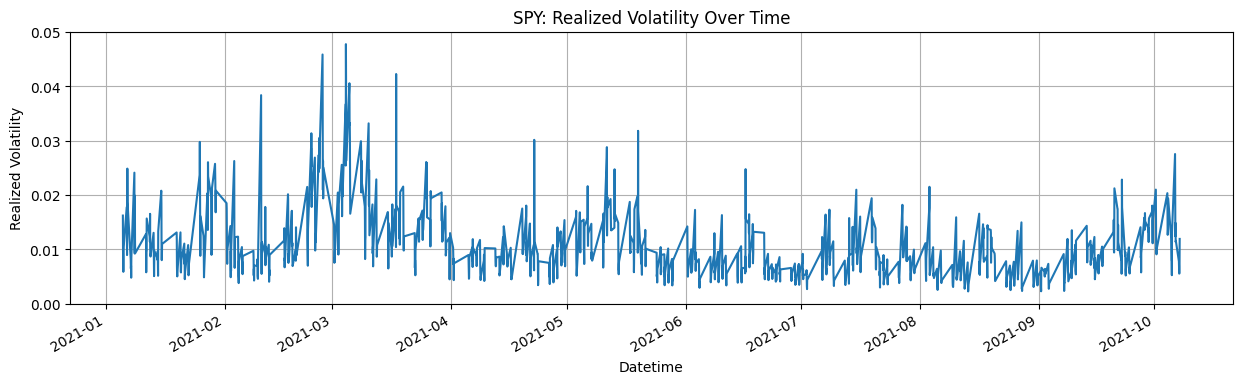

In [ ]:

#  Compute log returns (per time_id)
spy_df["log_return"] = spy_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))


# Compute realized volatility per time_id
rv_df = spy_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into spy_df
spy_df = pd.merge(spy_df, rv_df, on="time_id", how="left")

# Plot volatility over time
spy_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="SPY: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()



# HAV RV as baseline model
### train/test split on time id 80/20 with rolling window (W=330, H=10, S=5) 
### Different variants of HAV RV modeled - OLS, WLS, Ridge(regularized), Lasso(regularized)
## OLS

In [ ]:
# Helper function 

def evaluate_model(true, pred):
    # Clip predicted values to avoid log(0) or division by 0
    pred_clipped = np.clip(pred, 1e-4, None)
    true = np.array(true)
    
    # MSE
    mse = mean_squared_error(true, pred_clipped)

    # QLIKE
    try:
        qlike_score = np.mean(np.log(pred_clipped**2) + (true**2) / (pred_clipped**2))
    except Exception as e:
        qlike_score = np.nan
        print("QLIKE calculation failed:", e)

    print(f"Test MSE: {mse:.8f}")
    print(f"Test QLIKE: {qlike_score:.8f}")

    return mse, qlike_score


Test MSE: 0.00001229
Test QLIKE: -8.41993332


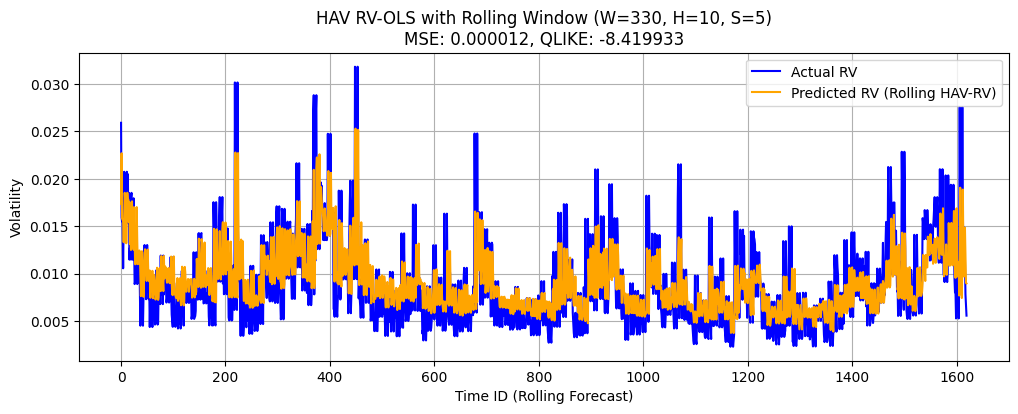

In [ ]:
# HAV RV OLS
# Prepare lagged HAV features
hav_df = rv_df.copy()
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5)
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10)
hav_df = hav_df.dropna().reset_index(drop=True)

# Set rolling window parameters
W, H, S = 330, 10, 5  # Window size, forecast horizon, step size

# Rolling window forecasting
all_preds = []
all_actuals = []

for start in range(0, len(hav_df) - W - H + 1, S):
    train_window = hav_df.iloc[start:start + W]
    test_window = hav_df.iloc[start + W:start + W + H]

    # Fit model on rolling window
    X_train = sm.add_constant(train_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    y_train = train_window["realized_volatility"]
    model = sm.OLS(y_train, X_train).fit()

    # Predict
    X_test = sm.add_constant(test_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(test_window["realized_volatility"].values)

# Evaluate 
preds = np.array(all_preds)
actuals = np.array(all_actuals)
#call helper function
mse_ols, qlike_ols = evaluate_model(actuals, preds)

# Plot predicted and actual volatility
plt.figure(figsize=(12, 4))
plt.plot(actuals, label="Actual RV", color="blue")
plt.plot(preds, label="Predicted RV (Rolling HAV-RV)", color="orange")
plt.title(f"HAV RV-OLS with Rolling Window (W={W}, H={H}, S={S})\nMSE: {mse_ols:.6f}, QLIKE: {qlike_ols:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

## wls

Test MSE: 0.00001420
Test QLIKE: -8.22214271


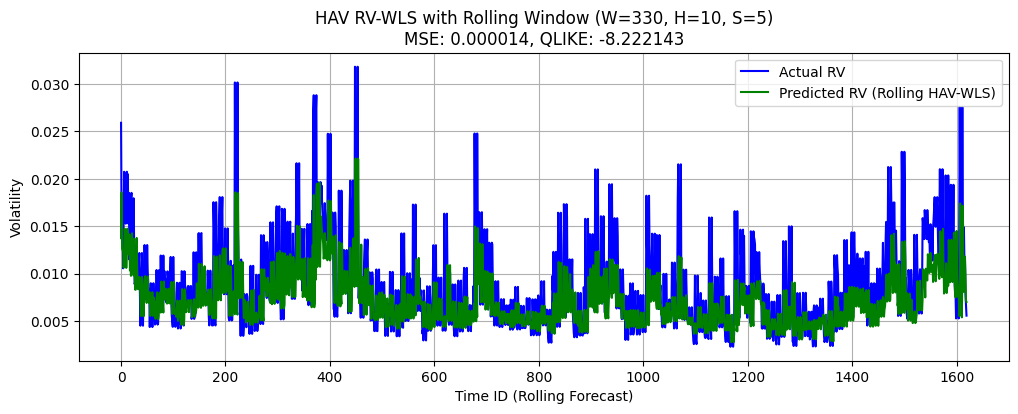

In [ ]:
# HAV RV WLS
# Prepare lagged HAV features
hav_df = rv_df.copy()
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5)
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10)
hav_df = hav_df.dropna().reset_index(drop=True)

# Set rolling window parameters
W, H, S = 330, 10, 5  # Window size, forecast horizon, step size

# Rolling window forecasting
all_preds = []
all_actuals = []

for start in range(0, len(hav_df) - W - H + 1, S):
    train_window = hav_df.iloc[start:start + W]
    test_window = hav_df.iloc[start + W:start + W + H]

    # Compute weights (inverse of squared RV)
    weights = 1 / (train_window["realized_volatility"] ** 2 + 1e-8)  # add epsilon to avoid div by zero

    # Fit WLS model on rolling window
    X_train = sm.add_constant(train_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    y_train = train_window["realized_volatility"]
    model = sm.WLS(y_train, X_train, weights=weights).fit()

    # Predict
    X_test = sm.add_constant(test_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(test_window["realized_volatility"].values)

# Evaluate 
preds = np.array(all_preds)
actuals = np.array(all_actuals)
mse_wls, qlike_wls = evaluate_model(actuals, preds)

# Plot predicted and actual volatility
plt.figure(figsize=(12, 4))
plt.plot(actuals, label="Actual RV", color="blue")
plt.plot(preds, label="Predicted RV (Rolling HAV-WLS)", color="green")
plt.title(f"HAV RV-WLS with Rolling Window (W={W}, H={H}, S={S})\nMSE: {mse_wls:.6f}, QLIKE: {qlike_wls:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


#  Ridge regression - regularize for overfitting 
 - Regularizes the coefficients (shrinks them slightly)

- Improves generalization (especially on small or noisy windows)

- Can handle multicollinearity better than OLS/WLS



Test MSE: 0.00001229
Test QLIKE: -8.42003277


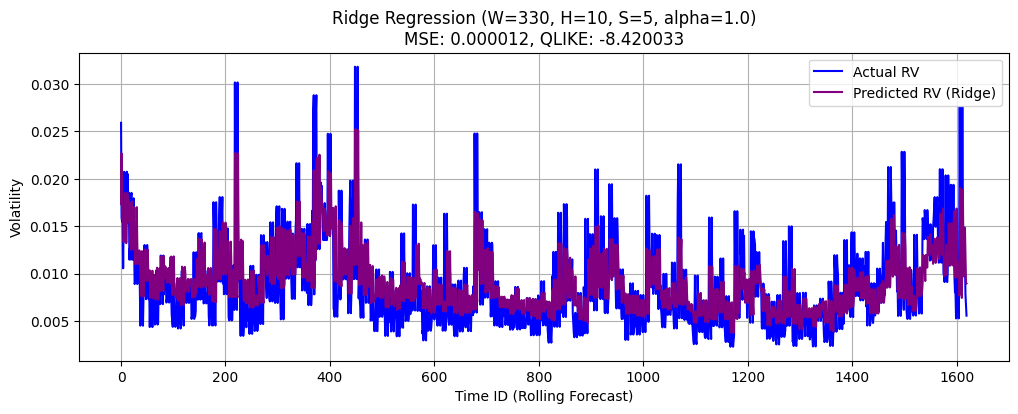

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Set rolling window parameters
W, H, S = 330, 10, 5
ridge_alpha = 1.0  # Can tune this later

# Store predictions
all_preds = []
all_actuals = []

for start in range(0, len(hav_df) - W - H + 1, S):
    train_window = hav_df.iloc[start:start + W]
    test_window = hav_df.iloc[start + W:start + W + H]

    X_train = train_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
    y_train = train_window["realized_volatility"]
    X_test = test_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]

    # Optional: scale features (helps with regularization stability)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Ridge model
    model = Ridge(alpha=ridge_alpha)
    model.fit(X_train_scaled, y_train)

    # Predict
    preds = model.predict(X_test_scaled)
    all_preds.extend(preds)
    all_actuals.extend(test_window["realized_volatility"].values)

# Evaluate
preds = np.array(all_preds)
actuals = np.array(all_actuals)
mse_ridge, qlike_ridge = evaluate_model(actuals, preds)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(actuals, label="Actual RV", color="blue")
plt.plot(preds, label="Predicted RV (Ridge)", color="purple")
plt.title(f"Ridge Regression (W={W}, H={H}, S={S}, alpha={ridge_alpha})\nMSE: {mse_ridge:.6f}, QLIKE: {qlike_ridge:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


# Ridge vs Lasso

Ridge and Lasso are regularized versions of linear regression, used to handle possible overfitting or multicollinearity that may not be addressed by HAV-RV using OLS or WLS.

Ridge:
Test MSE: 0.00000649

Test QLIKE: -9.17346600

Lasso:
Test MSE: 0.00000655

Test QLIKE: -9.17251048

- MSE (Mean Squared Error): Lower is better — Ridge is slightly better here.

- QLIKE (Quasi-Likelihood Error): Also lower is better — again, Ridge edges out Lasso.

- Conclusion: Both models perform very similarly, but Ridge outperforms by a little bit 

* extra: Ridge regression uses an L2 penalty (the sum of the squares of the coefficients), which shrinks all coefficients but keeps them. Lasso regression uses an L1 penalty (the sum of the absolute values of the coefficients), which can shrink some coefficients all the way to zero

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

# Parameters
W, H, S = 330, 10, 5
alphas = np.logspace(-4, 2, 20)  # Try alpha values from 0.0001 to 100
# It tests 20 different alpha values (from 0.0001 to 100) to find the best one during cross-validation.

# Storage
results = {}

for model_name, ModelCV in [("Ridge", RidgeCV), ("Lasso", LassoCV)]:
    all_preds = []
    all_actuals = []

    for start in range(0, len(hav_df) - W - H + 1, S):
        train_window = hav_df.iloc[start:start + W]
        test_window = hav_df.iloc[start + W:start + W + H]

        X_train = train_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
        y_train = train_window["realized_volatility"]
        X_test = test_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Cross-validated Ridge or Lasso
        model = ModelCV(alphas=alphas, cv=5)
        model.fit(X_train_scaled, y_train)

        preds = model.predict(X_test_scaled)
        all_preds.extend(preds)
        all_actuals.extend(test_window["realized_volatility"].values)

    # Evaluate
    print(f"\nModel: {model_name}")
    print(f"Best alpha: {model.alpha_:.6f}")
    preds = np.array(all_preds)
    actuals = np.array(all_actuals)
    mse, qlike = evaluate_model(actuals, preds)
    results[model_name] = {
        "preds": preds,
        "actuals": actuals,
        "mse": mse,
        "qlike": qlike,
        "best_alpha": model.alpha_
    }

# Save Ridge and Lasso metrics as separate variables
mse_ridge_a = results["Ridge"]["mse"]
qlike_ridge_a = results["Ridge"]["qlike"]

mse_lasso = results["Lasso"]["mse"]
qlike_lasso = results["Lasso"]["qlike"]



Model: Ridge
Best alpha: 0.000100
Test MSE: 0.00001230
Test QLIKE: -8.41996229

Model: Lasso
Best alpha: 0.000100
Test MSE: 0.00001237
Test QLIKE: -8.42087816


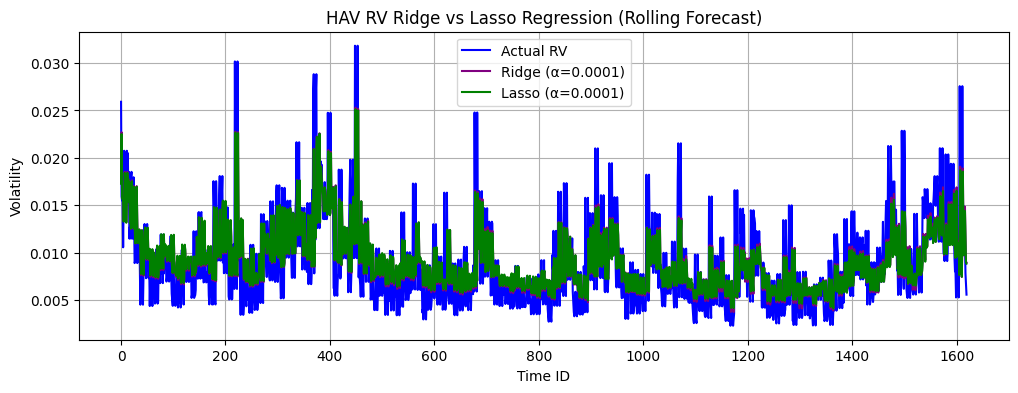

In [ ]:
# Plot Ridge vs Lasso
plt.figure(figsize=(12, 4))
plt.plot(results["Ridge"]["actuals"], label="Actual RV", color="blue")
plt.plot(results["Ridge"]["preds"], label=f"Ridge (α={results['Ridge']['best_alpha']:.4f})", color="purple")
plt.plot(results["Lasso"]["preds"], label=f"Lasso (α={results['Lasso']['best_alpha']:.4f})", color="green")
plt.title("HAV RV Ridge vs Lasso Regression (Rolling Forecast)")
plt.xlabel("Time ID")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

# Summary - HAV RV variant Selection

In [ ]:
# Create the formatted table
summary_data = {
    "Model": ["OLS", "WLS", "Ridge", "Ridge(a=0.0001)", "Lasso(a=0.0001)"],
    "MSE": [f"{mse_ols:.6f}", f"{mse_wls:.6f}", f"{mse_ridge:.6f}", f"{mse_ridge_a:.6f}", f"{mse_lasso:.6f}"],
    "QLIKE": [f"{qlike_ols:.6f}", f"{qlike_wls:.6f}", f"{qlike_ridge:.6f}" ,  f"{qlike_ridge_a:.6f}", f"{qlike_lasso:.6f}"]
}

summary_df = pd.DataFrame(summary_data)

# Print the table as plain text if desired
print(summary_df.to_string(index=False))


          Model      MSE     QLIKE
            OLS 0.000012 -8.419933
            WLS 0.000014 -8.222143
          Ridge 0.000012 -8.420033
Ridge(a=0.0001) 0.000012 -8.419962
Lasso(a=0.0001) 0.000012 -8.420878


In [ ]:
#!pip install statsmodels
#!pip install scikit-learn

